In [1]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
def processDf(df, split = True, separate=None):
    del df['Name']
    del df['PassengerId']
    del df['Ticket']
    df.Cabin = df.Cabin.fillna('-')
    
    if split:
        df = df.dropna()
        
    df.Pclass = df.Pclass.astype('str')
    df = pd.get_dummies(df)
    
    maxAge = max(df['Age'])
    
    validKeys = ['Age', 'SibSp', 'Pclass_1', 'Pclass_2', 'Sex_female', 'Cabin_-',
       'Cabin_A23', 'Cabin_B41', 'Cabin_C49', 'Cabin_D56', 'Cabin_E10',
       'Cabin_E25', 'Cabin_F2', 'Cabin_F4']
    
    if separate != None:
        separate = df[separate]
    
    for k in df.keys():
        if k not in validKeys:
            del df[k]
    
    # adjust order
    orderedDf = pd.DataFrame()

    for k in validKeys:
        if k not in df:
            print(k)
            df[k] = 0
        df[k] = df[k].fillna(df[k].mean())
        
        orderedDf[k] = df[k]
    
    orderedDf['Age'] = orderedDf['Age']/maxAge
    
    #split
    if split:
        train_size = 0.7
        splitPoint = math.floor(len(orderedDf) * train_size)

        dataset = orderedDf.values
#         np.random.shuffle(dataset)
        
        x_train = dataset[:splitPoint,:]
        y_train = separate[:splitPoint]

        x_test = dataset[splitPoint:]
        y_test = separate[splitPoint:]
    else:
        x_train = orderedDf.values
        y_train = None
        x_test = None
        y_test = None
        
    return {
        'x_train':x_train,
        'y_train':y_train,
        'x_test':x_test,
        'y_test':y_test,
        'separated':separate
    }

In [3]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df = pd.read_csv("train.csv")
tmp = processDf(df, separate='Survived')
x_train = tmp['x_train']
y_train = tmp['y_train'] 
x_test = tmp['x_test'] 
y_test = tmp['y_test'] 

all_x = np.append(x_train, x_test, 0)
all_y = np.append(y_train, y_test, 0)

x_shuffle = np.append(all_x, np.array([all_y]).reshape(len(all_x), 1), 1)
np.random.shuffle(x_shuffle)
y_shuffle = x_shuffle[:,-1]
x_shuffle = x_shuffle[:,:-1]

print("Train X:", x_train.shape)
print("Train Y:", y_train.shape, "\n")

print("Test X:", x_test.shape)
print("Test Y:", y_test.shape, "\n")

print("All X:", all_x.shape)
print("All Y:", all_y.shape, "\n")

print("X shuffle:", x_shuffle.shape)
print("Y shuffle:", y_shuffle.shape)

Train X: (498, 14)
Train Y: (498,) 

Test X: (214, 14)
Test Y: (214,) 

All X: (712, 14)
All Y: (712,) 

X shuffle: (712, 14)
Y shuffle: (712,)


## Info

In [5]:
def evaluate(y_pred, y_real):
    return np.sum(y_pred == y_real)/len(y_real)

## Models

#### DNN

In [6]:
# DNN
dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2690, input_shape=[x_shuffle.shape[1] + 2], activation='relu'),
    tf.keras.layers.Dense(1530, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(930, activation='relu'),
    tf.keras.layers.Dense(940, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(610, activation='relu'),
    tf.keras.layers.Dense(380, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(220, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2690)              45730     
_________________________________________________________________
dense_1 (Dense)              (None, 1530)              4117230   
_________________________________________________________________
dropout (Dropout)            (None, 1530)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 930)               1423830   
_________________________________________________________________
dense_3 (Dense)              (None, 940)               875140    
_________________________________________________________________
dropout_1 (Dropout)          (None, 940)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 610)               5

#### Linear regression (One layer-neuron perceptron)

In [7]:
olnp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=[all_x.shape[1]])
])
olnp.summary()
olnp.compile(optimizer='SGD', loss='mean_squared_error')
olnp.fit(x_train, y_train, batch_size=50, steps_per_epoch=10, epochs=500, verbose=0)

print('One neuron:', evaluate(olnp.predict(x_test).round().squeeze(), y_test), '%')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
One neuron: 0.7850467289719626 %


#### Ordinary least squares regression

In [8]:
olsr = sm.OLS(y_train, x_train).fit()
y_ols = olsr.predict(x_shuffle)
print('statsmodels:', evaluate(y_ols.round(), y_shuffle), '%')

statsmodels: 0.7907303370786517 %


## My super dataset

In [9]:
def maximize(arr):
    d = np.append(arr, olsr.predict(arr).reshape(-1, 1), 1)
    d = np.append(d, olnp.predict(arr).reshape(-1, 1), 1)
    
    return d

In [10]:
print(x_shuffle)
ds = maximize(x_shuffle)
ds.shape

[[0.025  1.     0.     ... 0.     0.     0.    ]
 [0.0125 1.     0.     ... 0.     0.     0.    ]
 [0.4    0.     1.     ... 0.     0.     0.    ]
 ...
 [0.775  0.     1.     ... 0.     0.     0.    ]
 [0.3375 0.     0.     ... 0.     0.     0.    ]
 [0.2875 2.     0.     ... 0.     0.     0.    ]]


(712, 16)

## Compile (only or DNN)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.11):
            print("\nReached 60% accuracy so cancelling training!")
            self.model.stop_training = True

In [12]:
dnn.compile(optimizer='SGD', loss='mean_squared_error')

## Train (DNN)

Epoch 1/600
15/15 [==============================] - 1s 58ms/step - loss: 0.2424
Epoch 2/600
15/15 [==============================] - 1s 62ms/step - loss: 0.2422
Epoch 3/600
15/15 [==============================] - 1s 57ms/step - loss: 0.2416
Epoch 4/600
15/15 [==============================] - 1s 58ms/step - loss: 0.2413
Epoch 5/600
15/15 [==============================] - 1s 58ms/step - loss: 0.2409
Epoch 6/600
15/15 [==============================] - 1s 56ms/step - loss: 0.2405
Epoch 7/600
15/15 [==============================] - 1s 56ms/step - loss: 0.2399
Epoch 8/600
15/15 [==============================] - 1s 56ms/step - loss: 0.2392
Epoch 9/600
15/15 [==============================] - 1s 59ms/step - loss: 0.2387
Epoch 10/600
15/15 [==============================] - 1s 57ms/step - loss: 0.2383
Epoch 11/600
15/15 [==============================] - 1s 56ms/step - loss: 0.2378
Epoch 12/600
15/15 [==============================] - 1s 46ms/step - loss: 0.2373
Epoch 13/600
15/15 [=====

15/15 [==============================] - 1s 52ms/step - loss: 0.1370
Epoch 102/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1372
Epoch 103/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1382
Epoch 104/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1375
Epoch 105/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1363
Epoch 106/600
15/15 [==============================] - 1s 56ms/step - loss: 0.1358
Epoch 107/600
15/15 [==============================] - 1s 56ms/step - loss: 0.1367
Epoch 108/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1362
Epoch 109/600
15/15 [==============================] - 1s 56ms/step - loss: 0.1343
Epoch 110/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1363
Epoch 111/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1364
Epoch 112/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1342
Epoch 113/600
15/1

15/15 [==============================] - 1s 50ms/step - loss: 0.1278
Epoch 200/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1269
Epoch 201/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1261
Epoch 202/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1274
Epoch 203/600
15/15 [==============================] - 1s 51ms/step - loss: 0.1273
Epoch 204/600
15/15 [==============================] - 1s 55ms/step - loss: 0.1272
Epoch 205/600
15/15 [==============================] - 1s 56ms/step - loss: 0.1274
Epoch 206/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1280
Epoch 207/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1256
Epoch 208/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1274
Epoch 209/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1277
Epoch 210/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1244
Epoch 211/600
15/1

15/15 [==============================] - 1s 50ms/step - loss: 0.1238
Epoch 298/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1225
Epoch 299/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1236
Epoch 300/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1239
Epoch 301/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1253
Epoch 302/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1209
Epoch 303/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1245
Epoch 304/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1242
Epoch 305/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1221
Epoch 306/600
15/15 [==============================] - 1s 54ms/step - loss: 0.1247
Epoch 307/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1237
Epoch 308/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1238
Epoch 309/600
15/1

15/15 [==============================] - 1s 50ms/step - loss: 0.1245
Epoch 396/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1230
Epoch 397/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1232
Epoch 398/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1228
Epoch 399/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1218
Epoch 400/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1256
Epoch 401/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1229
Epoch 402/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1201
Epoch 403/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1217
Epoch 404/600
15/15 [==============================] - 1s 51ms/step - loss: 0.1228
Epoch 405/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1231
Epoch 406/600
15/15 [==============================] - 1s 50ms/step - loss: 0.1218
Epoch 407/600
15/1

15/15 [==============================] - 1s 62ms/step - loss: 0.1218
Epoch 494/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1212
Epoch 495/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1195
Epoch 496/600
15/15 [==============================] - 1s 48ms/step - loss: 0.1209
Epoch 497/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1203
Epoch 498/600
15/15 [==============================] - 1s 48ms/step - loss: 0.1210
Epoch 499/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1201
Epoch 500/600
15/15 [==============================] - 1s 48ms/step - loss: 0.1204
Epoch 501/600
15/15 [==============================] - 1s 49ms/step - loss: 0.1211
Epoch 502/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1218
Epoch 503/600
15/15 [==============================] - 1s 51ms/step - loss: 0.1199
Epoch 504/600
15/15 [==============================] - 1s 51ms/step - loss: 0.1225
Epoch 505/600
15/1

15/15 [==============================] - 1s 58ms/step - loss: 0.1201
Epoch 592/600
15/15 [==============================] - 1s 59ms/step - loss: 0.1212
Epoch 593/600
15/15 [==============================] - 1s 57ms/step - loss: 0.1199
Epoch 594/600
15/15 [==============================] - 1s 55ms/step - loss: 0.1210
Epoch 595/600
15/15 [==============================] - 1s 55ms/step - loss: 0.1199
Epoch 596/600
15/15 [==============================] - 1s 55ms/step - loss: 0.1207
Epoch 597/600
15/15 [==============================] - 1s 51ms/step - loss: 0.1206
Epoch 598/600
15/15 [==============================] - 1s 53ms/step - loss: 0.1207
Epoch 599/600
15/15 [==============================] - 1s 52ms/step - loss: 0.1201
Epoch 600/600
15/15 [==============================] - 1s 56ms/step - loss: 0.1207
Evaluation:
23/23 [==============================] - 0s 16ms/step - loss: 0.1189


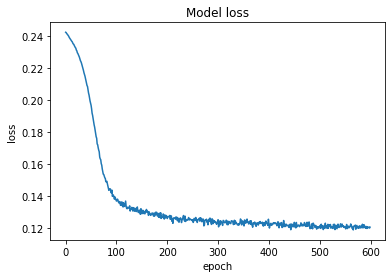

In [17]:
cback = myCallback()
history = dnn.fit(ds, y_shuffle, batch_size=50, steps_per_epoch=15, epochs=600, callbacks=[cback])
print('Evaluation:')
dnn.evaluate(ds, y_shuffle)

#plot
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model loss')
plt.show()

## Performance records

In [19]:
def dummyCheck(array, compareBy):
    array = dnn.predict(array)

    predictions = map(lambda x: np.squeeze(x).round(), array)
    predictions = np.array(list(predictions))

    return predictions == np.array(compareBy)


dds = maximize(x_train)
ddsT = maximize(x_test)

# print(y_train.shape, x_train.shape, dds.shape, dnn.predict(dds).shape, y_train.shape)
# print(y_test.shape, x_test.shape, ddsT.shape, dnn.predict(ddsT).shape, y_test.shape)

print('Training accuracy:', sum(dummyCheck(dds, y_train)) / len(y_train), '%')
print('Testing accuracy:', sum(dummyCheck(ddsT, y_test)) / len(y_test), '%')

# DNN x10 Combined
# Training accuracy: 0.8373493975903614 %
# Testing accuracy: 0.8504672897196262 %

# DNN neurons 10x - p-value optimized
# Training accuracy: 0.8373493975903614 %
# Testing accuracy: 0.8317757009345794 %

# DNN neurons 10x - p-value partial optimized
# Training accuracy: 0.8132530120481928 %
# Testing accuracy: 0.8317757009345794 %

# DNN neurons 10x
# Training accuracy: 0.7951807228915663 %
# Testing accuracy: 0.8271028037383178 %

# DNN 
# Training accuracy: 0.7409638554216867 %
# Testing accuracy: 0.7850467289719626 %

# Linear Regression
# Training accuracy: 0.7871485943775101 %
# Testing accuracy: 0.7850467289719626 %

Training accuracy: 0.8353413654618473 %
Testing accuracy: 0.8411214953271028 %


## Saving the model (DNN 10x)

In [21]:
!ls *.h5
dnn.save('DNN10x_and_regressions.h5')

DNN10x_and_regressions.h5  DNN10x.h5  DNN10x_pvalue.h5


## Loading the model

In [20]:
# model = tf.keras.models.load_model('DNN10x_pvalue.h5')

## Make predictions file

In [22]:
dfTesting = pd.read_csv('test.csv')

dfResult = pd.DataFrame()
dfResult['PassengerId'] = dfTesting['PassengerId']

dfTesting = processDf(dfTesting, False)

ds = np.append(dfTesting['x_train'], olsr.predict(dfTesting['x_train']).reshape(-1, 1), 1)
ds = np.append(ds, olnp.predict(dfTesting['x_train']).reshape(-1, 1), 1)

assert len(ds[0]) == dnn.input_shape[1]

# 0.2894736842105263 % will be survive
# 0.4044943820224719 % survived in real data

dfResult['Survived'] = dnn.predict(ds).round().astype(int)

print(dfResult['Survived'].sum()/len(dfResult['Survived']), '% will be survive')

dfResult.to_csv('result_mean_multi.csv', index=False)

dfResult

Cabin_A23
Cabin_C49
Cabin_D56
Cabin_E10
Cabin_E25
0.2631578947368421 % will be survive


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
